In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from os import walk
import numpy as np
from tqdm import tqdm
from astropy.time import Time
from os.path import join
import os
import sys

ROOT = os.path.dirname(os.path.abspath(""))
print(ROOT)
sys.path.insert(1, ROOT)


from matplotlib.patches import Wedge, Rectangle
from src.cmesrc.config import SWAN_DATA_DIR, ALL_MATCHING_HARPS_DATABASE_PICKLE, SCORED_HARPS_MATCHING_DIMMINGS_DATABASE_PICKLE, OVERVIEW_FIGURES_DIR, SCORED_HARPS_MATCHING_FLARES_DATABASE_PICKLE, MAIN_DATABASE_PICKLE
from src.cmesrc.utils import get_closest_harps_timestamp
from src.harps.harps import Harps
from src.cmes.cmes import CME
from src.flares.flares import Flare
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Angle
from sunpy.coordinates import frames
from src.dimmings.dimmings import Dimming
import sunpy.map
!pip install 

import sunpy.net.attrs as a

/home/julio/cmesrc
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 5.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


ModuleNotFoundError: No module named 'bs4'

In [10]:
transparent_white = (1, 1, 1, 0.4)
a.Instrument("AIA")
a.AIA

%%--%%| <mfz9tKX7rF|WhTajwwSLc>

In [11]:
main_data = pd.read_pickle(MAIN_DATABASE_PICKLE)

In [12]:
harps_data = pd.read_pickle(MAIN_DATABASE_PICKLE)
harps_data.set_index("CME_ID", drop=True, inplace=True)
dimmings_data = pd.read_pickle(SCORED_HARPS_MATCHING_DIMMINGS_DATABASE_PICKLE)
dimmings_data.set_index("CME_ID", drop=True, inplace=True)

In [13]:
flares_data = pd.read_pickle(SCORED_HARPS_MATCHING_FLARES_DATABASE_PICKLE)
flares_data.set_index("CME_ID", drop=True, inplace=True)

In [14]:
grouped_main_data = main_data.groupby("CME_ID")

In [15]:
grouped_harps_data = harps_data.groupby("CME_ID")
grouped_dimmings_data = dimmings_data.groupby("CME_ID")
grouped_flares_data = flares_data.groupby("CME_ID")

%%--%%| <WhTajwwSLc|xM1yvXYPEM>

%%--%%| <xM1yvXYPEM|EF3HcZV3Xn>

In [16]:
def plot_cme(ax, sunpy_map, principal_angle, angular_width, halo = False, distance=0.95, npoints=100, linestyle="solid", color="green", linewidth=1, alpha=1):
    center = sunpy_map.world_to_pixel(sunpy_map.center)
    rad = min(center) * distance
    if halo:
        principal_angle = Angle('0d')
        angular_width = Angle('359.99d')
    else:
        principal_angle = Angle(f'{principal_angle}d')
        angular_width = Angle(f'{angular_width}d')
    ninety_deg = Angle('90d')
    lower_angle = (principal_angle + ninety_deg - angular_width / 2).to(u.rad)
    upper_angle = (principal_angle + ninety_deg + angular_width / 2).to(u.rad)
    angles = np.linspace(lower_angle, upper_angle, npoints)
    modified_x = []
    modified_y = []
    for angle in angles:
        modified_x.append((rad * np.cos(angle)).value) 
        modified_y.append((rad * np.sin(angle)).value)
    if not halo:
        modified_x.insert(0,0)
        modified_y.insert(0,0)
        modified_x.append(0)
        modified_y.append(0)
    modified_x = np.array(modified_x) * u.pix
    modified_y = np.array(modified_y) * u.pix
    real_x = modified_x + center[0]
    real_y = modified_y + center[1]
    points = SkyCoord(np.array(list(map(sunpy_map.pixel_to_world, real_x, real_y))))
    ax.plot_coord(points, c=color, linewidth=linewidth, linestyle=linestyle, label=f"PA={principal_angle}, WIDTH={angular_width}", zorder=20, alpha=alpha)
    return ax

In [17]:
def generate_blank_map():
    observer = frames.HeliographicStonyhurst(0 * u.rad, 0 * u.rad, radius= 1 * u.AU)
    header_data = np.full((10, 10), np.nan)
    ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=cme_time,
                    observer=observer, frame=frames.Helioprojective)
    header = sunpy.map.make_fitswcs_header(header_data, ref_coord, scale=[220, 220]*u.arcsec/u.pixel)
    blank_map = sunpy.map.Map(header_data, header)
    return blank_map

In [18]:
N = 500

 14%|█▍        | 577/4132 [02:30<15:29,  3.83it/s]  


KeyboardInterrupt: 

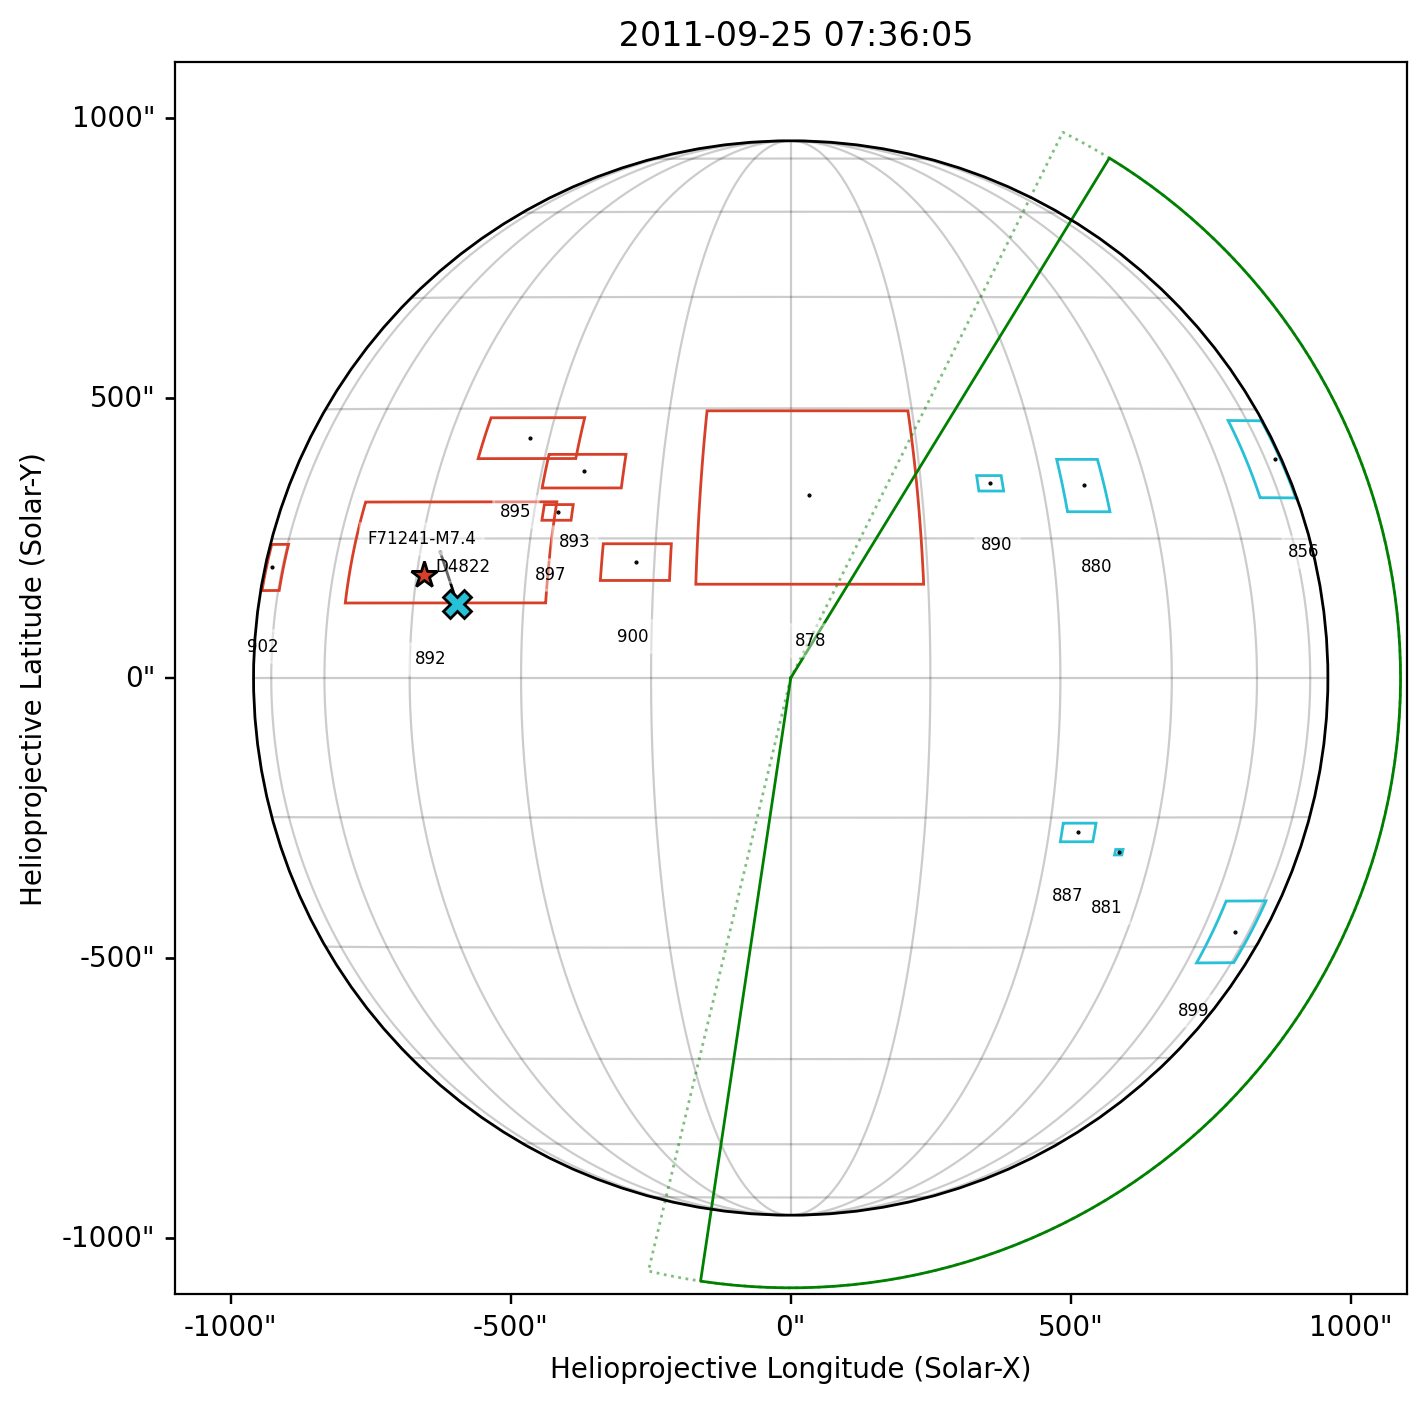

In [20]:
for cme_id in tqdm(list(grouped_harps_data.groups.keys())):

    harps_rows = grouped_harps_data.get_group(cme_id)

    if cme_id in dimmings_data.index:
        dimming_rows = grouped_dimmings_data.get_group(cme_id)
    else:
        dimming_rows = []

    if cme_id in flares_data.index:
        flare_rows = grouped_flares_data.get_group(cme_id)
    else:
        flare_rows = []

    if not ((len(dimming_rows) > 0) and (len(flare_rows) > 0)):
        continue

    cme_time = harps_rows["CME_DATE"].to_list()[0]
    cme_pa = harps_rows["CME_PA"].to_list()[0]
    cme_width = harps_rows["CME_WIDTH"].to_list()[0]
    cme_halo = harps_rows["CME_HALO"].to_list()[0]

    cme = CME(cme_time, cme_pa, cme_width, halo=cme_halo)

    blank_map = generate_blank_map()

    fig = plt.figure(figsize=(8,8), dpi=200)
    ax = fig.add_subplot(projection=blank_map)

    blank_map.plot(axes=ax)
    blank_map.draw_limb(axes=ax, color="k")
    blank_map.draw_grid(axes=ax, color="k", zorder=-1, alpha=0.2)
#
    plot_cme(ax, blank_map, cme_pa, cme_width, distance=1.1, npoints=100, halo=cme_halo)

    if not cme_halo:
        plot_cme(ax, blank_map, cme_pa, cme_width + cme.WIDTH_EXTRA_ANGLE, distance=1.1, npoints=100, linewidth=1, linestyle="dotted", alpha=0.5)


    plotted_harps_dict = dict()

    for idx, harps_data_row in harps_rows.iterrows():

        harps_data_values = harps_data_row[["CME_DATE","HARPS_LON_MIN","HARPS_LAT_MIN","HARPS_LON_MAX","HARPS_LAT_MAX"]]

        harpsnum = harps_data_row["HARPNUM"]

        harps = Harps(*harps_data_values)
        rotated_harps = harps.rotate_bbox(cme_time)

        plotted_harps_dict[harpsnum] = rotated_harps

        if not harps_data_row["HARPS_SPAT_CONSIST"]:
            color = "#D73F28"
        else:
            color = "#28C0D7"

        blank_map.draw_quadrangle(
                bottom_left=rotated_harps.LOWER_LEFT.get_skycoord(),
                top_right=rotated_harps.UPPER_RIGHT.get_skycoord(),
                axes=ax,
                zorder=10,
                edgecolor=color,
                )

        ax.annotate(harpsnum, 
                    (rotated_harps.get_centre_point().LON, rotated_harps.get_centre_point().LAT),
                    xytext=(rotated_harps.get_centre_point().LON, rotated_harps.LOWER_LEFT.LAT-5),
                    xycoords=ax.get_transform('heliographic_stonyhurst'),
                    backgroundcolor=transparent_white,
                    color='k',
                    horizontalalignment='center', 
                    verticalalignment='top',
                    fontsize=6,
                    zorder=30
                    )


        ax.plot_coord(rotated_harps.get_centre_point().get_skycoord(), c="k", zorder=10, marker=".", markersize=1)

    if len(dimming_rows) > 0:
        for dimming_id, dimming_data_rows in dimming_rows.groupby("DIMMING_ID"):
            dimming_data_rows = dimming_data_rows.sort_values(by="MATCH", ascending=False)

            dimming_data = dimming_data_rows.iloc[0]
            matched_dimming = dimming_data["MATCH"] == 1

            if matched_dimming:
                color = "#28C0D7"
            else:
                color = "#D73F28"

            dimming = Dimming(
                    date = dimming_data["DIMMING_TIME"],
                    lon = dimming_data["DIMMING_LON"],
                    lat = dimming_data["DIMMING_LAT"]
                    )

            dimming_skycoord = dimming.point.rotate_coords(cme_time).get_skycoord()

            ax.plot_coord(dimming_skycoord, c=color, zorder=10, marker="X", markersize=10, markeredgecolor="k")

            ax.annotate(f"D{dimming_id}", 
                        (0, 0),
                        xytext=(dimming.point.LON, dimming.point.LAT + 5),
                        xycoords=ax.get_transform('heliographic_stonyhurst'),
                        backgroundcolor=transparent_white,
                        color='k',
                        horizontalalignment='center', 
                        verticalalignment='top',
                        fontsize=6,
                        zorder=10
                        )

                
            if matched_dimming:
                harps_centre = plotted_harps_dict[dimming_data["HARPNUM"]].get_centre_point().get_skycoord()
                line = SkyCoord([dimming_skycoord, harps_centre])
                ax.plot_coord(line, c="k", linewidth=1, zorder=5)


    if len(flare_rows) > 1:
        for flare_id, flare_data_rows in flare_rows.groupby("FLARE_ID"):
            flare_data_rows = flare_data_rows.sort_values(by="MATCH", ascending=False)

            flare_data = flare_data_rows.iloc[0]
            matched_flare = flare_data["MATCH"] == 1
            flare_class = flare_data["FLARE_CLASS"]

            if matched_flare:
                color = "#28C0D7"
            else:
                color = "#D73F28"

            flare = Flare(
                    date = flare_data["FLARE_TIME"],
                    lon = flare_data["FLARE_LON"],
                    lat = flare_data["FLARE_LAT"]
                    )

            flare_skycoord = flare.point.rotate_coords(cme_time).get_skycoord()

            ax.plot_coord(flare_skycoord, c=color, zorder=10, marker="*", markersize=10, markeredgecolor="k")

            ax.annotate(f"F{flare_id}-{flare_class}", 
                        (0, 0),
                        xytext=(flare.point.LON, flare.point.LAT + 5),
                        xycoords=ax.get_transform('heliographic_stonyhurst'),
                        backgroundcolor=transparent_white,
                        color='k',
                        horizontalalignment='center', 
                        verticalalignment='top',
                        fontsize=6,
                        zorder=10
                        )
                
            if matched_flare:
                harps_centre = plotted_harps_dict[flare_data["HARPNUM"]].get_centre_point().get_skycoord()
                line = SkyCoord([flare_skycoord, harps_centre])
                ax.plot_coord(line, c="k", linewidth=1, zorder=5)

    plt.savefig(OVERVIEW_FIGURES_DIR + str(cme_id) + ".png", dpi=100, facecolor="#555555")
    plt.savefig(OVERVIEW_FIGURES_DIR + str(cme_id) + ".svg", bbox_inches="tight")
    plt.clf()
    plt.cla()
    plt.close()
